In [377]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
import matplotlib.pyplot as plt
import seaborn as sns

import json
import glob

import scipy.stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [378]:
def confidence_interval(data, percentage=95):
    if percentage == 95:
        z = 1.96
    else:
        raise(ValueError("frero..."))
    
    std = np.std(data)
    N = data.shape[0]

    diff = z * std/np.sqrt(N)

    return diff

In [379]:
json_regions = "/neurospin/dico/data/deep_folding/current/sulci_regions_gridsearch.json"
result_file = "/home/jc225751/Nextcloud/Travail/04 - Projects/flanker_per_region_on_HCP.ods" 
bdd_path = "/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary"

In [380]:
with open(json_regions) as f:
    regions = json.load(f)

In [381]:
res = pd.read_excel(result_file)
res = res.rename(columns = {"Region (sulci_region_gridsearch)": "region",
                            "Region name without ‘.’ (for yaml configuration)": "region_simple_name"}).drop(res.columns[2:10], axis=1)
res = res.assign(bdd=None)

res = res.dropna(subset = ['AUC'])
res.head()

,region,region_simple_name,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,std_auc_narrow,AUC-2_narrow,std_auc-2_narrow,bdd
0,CINGULATE.,cingulate,0.559,0.019,0.560,0.019,0.546,0.028,0.553,0.008,0.552,0.008,None
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,0.494,0.023,0.488,0.027,0.488,0.014,NaN,NaN,NaN,NaN,None
2,Sc.Cal.-S.Li.,pericalcarine,0.554,0.032,0.554,0.032,0.535,0.030,NaN,NaN,NaN,NaN,None
3,S.T.s.,STs,0.516,0.041,0.530,0.036,0.516,0.041,NaN,NaN,NaN,NaN,None
4,S.T.s.br.,STs_br,0.468,0.009,0.468,0.009,0.468,0.009,NaN,NaN,NaN,NaN,None


# Loop over bdd

In [382]:
def return_bdd(region_simple_name):
    csv_file = glob.glob(f"{bdd_path}/bdd_*{region_simple_name}.csv")
    if len(csv_file):
        print(csv_file[0])
        return pd.read_csv(csv_file[0], index_col=0)
    else: 
        print(f"{region_simple_name} without csv")
        return pd.DataFrame()

In [383]:
def compute_logp(auc, std_auc):
    p = scipy.stats.ttest_ind_from_stats(mean1=auc, 
                              std1=std_auc, 
                              nobs1=5, 
                              mean2=0.5, 
                              std2=0, 
                              nobs2=2, 
                              alternative='greater',
                              equal_var=False)[1]
    return -np.log10(p)

In [384]:
def process_bdd(row):

    print(row.bdd)
    bdd = row.bdd
    res_d = {}

    if bdd.empty:
        res_d["AUC_criterion"] = np.nan
        res_d['logp_AUC'] = np.nan
        res_d["std_auc_criterion"] = np.nan
        res_d["AUC_old_criterion"] = np.nan
        res_d["std_auc_old_criterion"] = np.nan
        res_d["AUC_best_val"] = np.nan
        res_d["std_auc_best_val"] = np.nan
        res_d["AUC_best_model"] = np.nan
        res_d["std_auc_best_model"] = np.nan
        res_d['log_lr'] = np.nan
        res_d['std_log_lr'] = np.nan
    else:
        res_d["AUC_criterion"] = np.nan
        res_d['logp_AUC'] = np.nan
        res_d["std_auc_criterion"] = np.nan
        res_d["AUC_old_criterion"] = np.nan
        res_d["std_auc_old_criterion"] = np.nan
        res_d["AUC_best_val"] = np.nan
        res_d["std_auc_best_val"] = np.nan
        res_d["AUC_best_model"] = np.nan
        res_d["std_auc_best_model"] = np.nan
        res_d['log_lr'] = np.nan
        res_d['std_log_lr'] = np.nan
        # Compute criterions
        bdd["criterion"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
        bdd["criterion_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
        bdd["criterion_best"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])

        # Make bdds rearranged according to criterion
        best_end = bdd.sort_values(by=['criterion'], ascending=True)[:5]
        best_end_old = bdd.sort_values(by=['criterion_old'], ascending=True)[:5]
        best_val_end = bdd.sort_values(by=['val_auc'], ascending=False)[:5]
        best_best = bdd.sort_values(by=['criterion_best'], ascending=True)[:5]


        # Compute AUCs
        res_d["AUC_criterion"] = best_end['test_auc'].mean()
        res_d["std_auc_criterion"] = best_end['test_auc'].std()
        res_d['logp_AUC'] = compute_logp(res_d["AUC_criterion"], res_d["std_auc_criterion"])
        res_d["AUC_old_criterion"] = best_end_old['test_auc'].mean()
        res_d["std_auc_old_criterion"] = best_end_old['test_auc'].std()
        res_d["AUC_best_val"] = best_val_end['test_auc'].mean()
        res_d["std_auc_best_val"] = best_val_end['test_auc'].std()
        res_d["AUC_best_model"] = best_best['best_test_auc'].mean()
        res_d["std_auc_best_model"] = best_best['best_test_auc'].std()
        res_d["log_lr"] = (-np.log10(best_end['lr'])).mean()
        res_d["std_log_lr"] = (-np.log10(best_end['lr'])).std()


    return pd.Series(res_d)

In [385]:
res["bdd"] = res["region_simple_name"].apply(return_bdd)

/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-11_cingulate.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-12_BROCA.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-21_pericalcarine.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-20_STs.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-27_STs_br.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-26_central.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-14_central_precentral.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-19_central_postcentral.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-21_SOr.csv
/neurospin/dico/jchavas/Runs/61_classifier_regresser/

In [386]:
res = res.join(res.apply(process_bdd, axis="columns"))


                                           model_path  train_auc   val_auc  \
0   /volatile2/jc225751/Runs/61_classifier_regress...   0.992984  0.653191   
1   /volatile2/jc225751/Runs/61_classifier_regress...   0.557359  0.588707   
2   /volatile2/jc225751/Runs/61_classifier_regress...   0.599898  0.607856   
3   /volatile2/jc225751/Runs/61_classifier_regress...   1.000000  0.621604   
4   /volatile2/jc225751/Runs/61_classifier_regress...   0.998265  0.615712   
..                                                ...        ...       ...   
36  /volatile2/jc225751/Runs/61_classifier_regress...   0.662320  0.547954   
37  /volatile2/jc225751/Runs/61_classifier_regress...   0.541615  0.516039   
38  /volatile2/jc225751/Runs/61_classifier_regress...   0.500000  0.500000   
39  /volatile2/jc225751/Runs/61_classifier_regress...   0.580322  0.576432   
40  /volatile2/jc225751/Runs/61_classifier_regress...   0.996717  0.620622   

    test_auc  best_train_auc  best_val_auc  best_test_auc  drop

In [387]:
res.head()

,region,region_simple_name,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,std_auc_narrow,...,logp_AUC,std_auc_criterion,AUC_old_criterion,std_auc_old_criterion,AUC_best_val,std_auc_best_val,AUC_best_model,std_auc_best_model,log_lr,std_log_lr
0,CINGULATE.,cingulate,0.559,0.019,0.560,0.019,0.546,0.028,0.553,0.008,...,2.669469,0.018789,0.559192,0.018789,0.546378,0.027564,0.561097,0.039295,2.653998,0.434632
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,0.494,0.023,0.488,0.027,0.488,0.014,NaN,NaN,...,-0.000000,0.023101,0.488369,0.026592,0.487792,0.013850,0.508369,0.024027,2.386500,0.193476
2,Sc.Cal.-S.Li.,pericalcarine,0.554,0.032,0.554,0.032,0.535,0.030,NaN,NaN,...,1.701832,0.032004,0.553737,0.032004,0.535296,0.030075,0.560029,0.028885,2.547291,0.483520
3,S.T.s.,STs,0.516,0.041,0.530,0.036,0.516,0.041,NaN,NaN,...,0.374336,0.040687,0.529697,0.032967,0.516248,0.040687,0.515556,0.041121,3.205652,0.280429
4,S.T.s.br.,STs_br,0.468,0.009,0.468,0.009,0.468,0.009,NaN,NaN,...,-0.000000,0.009148,0.468341,0.009148,0.468341,0.009148,0.482482,0.031245,3.000318,0.329289


/tmp/ipykernel_36678/2997021409.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(res.region_simple_name, res.log_lr, res.std_log_lr, fmt='.', marker='o')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, 'cingulate'),
  Text(1, 0, 'BROCA'),
  Text(2, 0, 'pericalcarine'),
  Text(3, 0, 'STs'),
  Text(4, 0, 'STs_br'),
  Text(5, 0, 'central'),
  Text(6, 0, 'central_precentral'),
  Text(7, 0, 'central_postcentral'),
  Text(8, 0, 'SOr'),
  Text(9, 0, 'FCMpost'),
  Text(10, 0, 'SFmedian'),
  Text(11, 0, 'SFintermediate'),
  Text(12, 0, 'SFinferior'),
  Text(13, 0, 'SFinternal'),
  Text(14, 0, 'occipito_temporal'),
  Text(15, 0, 'occipital'),
  Text(16, 0, 'intraparietal'),
  Text(17, 0, 'internal_parietal'),
  Text(18, 0, 'lobule_parietal_sup'),
  Text(19, 0, 'inferior_temporal'),
  Text(20, 0, 'fissure_collateral'),
  Text(21, 0, 'fissure_lateral'),
  Text(22, 0, 'fissure_parieto_occipital'),
  Text(23, 0, 'fronto-parietal_medial_face')])

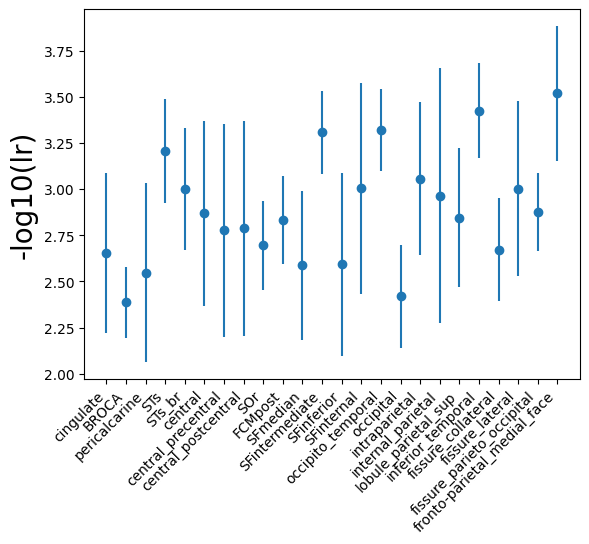

In [388]:
plt.errorbar(res.region_simple_name, res.log_lr, res.std_log_lr, fmt='.', marker='o')
plt.ylabel("-log10(lr)")
plt.xticks(rotation=45, ha="right")

Text(0, 0.5, 'AUC')

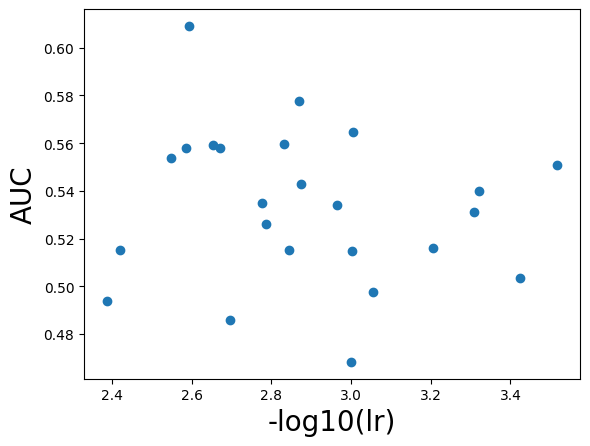

In [389]:
plt.scatter(res.log_lr, res.AUC_criterion)
plt.xlabel("-log10(lr)")
plt.ylabel("AUC")

In [390]:
res.logp_AUC

0     2.669469
1    -0.000000
2     1.701832
3     0.374336
4    -0.000000
        ...   
20    0.203098
21    2.549062
22    0.956822
23    1.669155
24    1.921104
Name: logp_AUC, Length: 24, dtype: float64

In [391]:
def plot_manhattan(res, region_name, ax):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)

    print(res.columns)
    
    res["line"] = 1.3
    markerline, stemlines, baseline = \
        ax.stem(res[region_name],
              res.logp_AUC,
              basefmt= 'C0',
              linefmt=':')
    plt.setp(markerline, 'color', 'black')
    plt.setp(stemlines, 'color', 'black')
    plt.setp(baseline, 'color', 'black')
    plt.xticks(rotation=45, ha="right")
    ax.plot(res[region_name], res.line, c='black')
    ax.set_ylabel("-log10(p)", labelpad=3.0)
    # ax.set_xlabel("regions", labelpad=10.0)
    ax2 = ax.twinx()
    ax2.xaxis.set_tick_params(labelsize = labelsize)
    ax2.yaxis.set_tick_params(labelsize = labelsize)
    ax2.plot(res[region_name], res.AUC, c='blue')
    ax2.set_ylim([0.48,0.66])
    ax2.set_ylabel('AUC', color='b', rotation=270, labelpad=25)
    ax2.set_yticks([0.5, 0.55, 0.6, 0.65])
    ax2.spines['right'].set_color('blue')
    ax2.tick_params(axis='y', colors='blue')
    ax2.set_ylim(0.46)


Index(['region', 'region_simple_name', 'AUC', 'std_auc', 'AUC-1', 'std_auc-1',
       'AUC-2', 'std_auc-2', 'AUC_narrow', 'std_auc_narrow', 'AUC-2_narrow',
       'std_auc-2_narrow', 'bdd', 'AUC_criterion', 'logp_AUC',
       'std_auc_criterion', 'AUC_old_criterion', 'std_auc_old_criterion',
       'AUC_best_val', 'std_auc_best_val', 'AUC_best_model',
       'std_auc_best_model', 'log_lr', 'std_log_lr'],
      dtype='object')


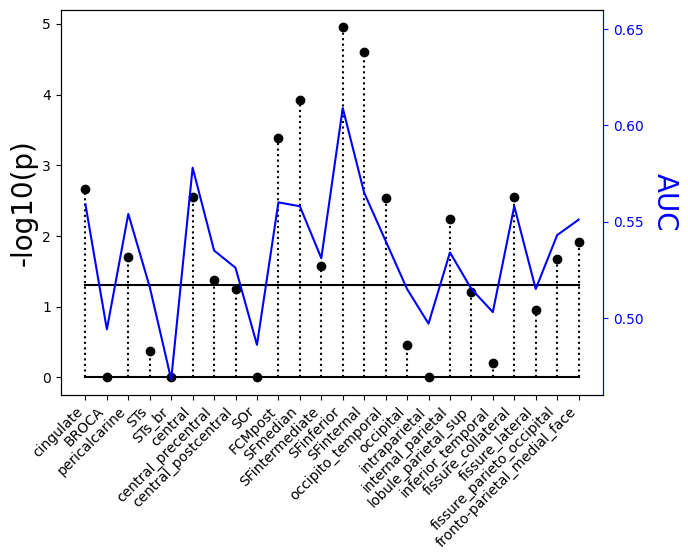

In [392]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res, "region_simple_name", ax)
plt.show()

Index(['region', 'region_simple_name', 'AUC', 'std_auc', 'AUC-1', 'std_auc-1',
       'AUC-2', 'std_auc-2', 'AUC_narrow', 'std_auc_narrow', 'AUC-2_narrow',
       'std_auc-2_narrow', 'bdd', 'AUC_criterion', 'logp_AUC',
       'std_auc_criterion', 'AUC_old_criterion', 'std_auc_old_criterion',
       'AUC_best_val', 'std_auc_best_val', 'AUC_best_model',
       'std_auc_best_model', 'log_lr', 'std_log_lr', 'line'],
      dtype='object')


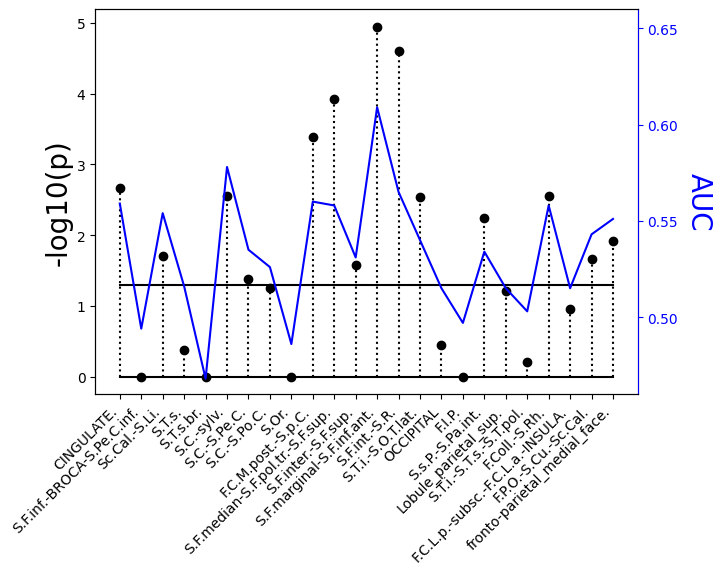

In [393]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res, "region", ax)
plt.show()

# bdd

In [394]:
bdd = pd.read_csv("/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-26_inferior_temporal.csv", index_col=0)
bdd = bdd.sort_values(by=['best_test_auc'], ascending=False)

In [395]:
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss
9,/home_local/jc225751/Runs/61_classifier_regres...,0.464740,0.473650,0.501443,0.557953,0.621440,0.532468,0.139103,0.992356,0.006592,138.673721
4,/home_local/jc225751/Runs/61_classifier_regres...,0.626189,0.677905,0.532179,0.621787,0.676923,0.531025,0.286876,0.850695,0.000102,138.452469
5,/home_local/jc225751/Runs/61_classifier_regres...,0.611398,0.524714,0.517172,0.565051,0.630769,0.527850,0.071892,0.736797,0.000510,138.398804
30,/home_local/jc225751/Runs/61_classifier_regres...,0.823671,0.589853,0.534199,0.603511,0.665794,0.524531,0.075156,0.838581,0.000351,131.535904
3,/home_local/jc225751/Runs/61_classifier_regres...,0.688971,0.526678,0.485137,0.621937,0.668412,0.522367,0.163359,0.708882,0.000166,137.460846


AUC = 0.5034632034632034 +/- 0.014712247158412475
AUC-1 = 0.4979797979797979 +/- 0.019979708560614897
AUC-2 = 0.5034632034632034 +/- 0.014712247158412475
AUC (best model) = 0.4868398268398268 +/- 0.011782528717717053


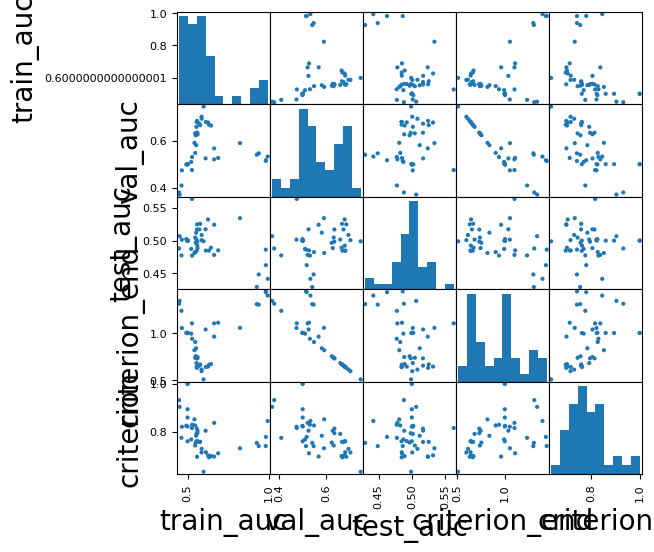

In [396]:
bdd["criterion"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])
bdd["criterion_end_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
bdd["criterion_end"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
best_end = bdd.sort_values(by=['criterion_end'], ascending=True)[:5]
best_end_old = bdd.sort_values(by=['criterion_end_old'], ascending=True)[:5]
best_val_end = bdd.sort_values(by=['val_auc'], ascending=False)[:5]
best_best = bdd.sort_values(by=['criterion'], ascending=True)[:5]
print(f"AUC = {best_end['test_auc'].mean()} +/- {best_end['test_auc'].std()}")
print(f"AUC-1 = {best_end_old['test_auc'].mean()} +/- {best_end_old['test_auc'].std()}")
print(f"AUC-2 = {best_val_end['test_auc'].mean()} +/- {best_val_end['test_auc'].std()}")
print(f"AUC (best model) = {best_best['best_test_auc'].mean()} +/- {best_best['best_test_auc'].std()}")
obj = pd.plotting.scatter_matrix(bdd[['train_auc', 'val_auc', 'test_auc', 'criterion_end', 'criterion']],
                                 figsize=(6,6),
                                 alpha=1.0)

In [397]:
bdd = bdd.sort_values(by=['criterion_end'], ascending=True)
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss,criterion,criterion_end_old,criterion_end
36,/home_local/jc225751/Runs/61_classifier_regres...,0.598809,0.745827,0.498990,0.606531,0.760884,0.491631,0.124402,0.894893,0.000229,138.630814,0.632586,0.655365,0.508347
41,/home_local/jc225751/Runs/61_classifier_regres...,0.586309,0.702455,0.500722,0.585460,0.701473,0.496392,0.254461,0.794546,0.000321,138.583435,0.713067,0.711236,0.595090
32,/home_local/jc225751/Runs/61_classifier_regres...,0.587068,0.693944,0.508514,0.586287,0.685434,0.513997,0.217545,0.875238,0.000247,138.776733,0.728280,0.718988,0.612111
18,/home_local/jc225751/Runs/61_classifier_regres...,0.558944,0.684779,0.524675,0.604262,0.700491,0.466955,0.239622,0.898063,0.000417,138.457809,0.695247,0.756277,0.630442
17,/home_local/jc225751/Runs/61_classifier_regres...,0.556052,0.680360,0.484416,0.557547,0.682488,0.481097,0.239798,0.867935,0.000988,138.769058,0.759965,0.763588,0.639280


Text(0, 0.5, 'best_test_auc')

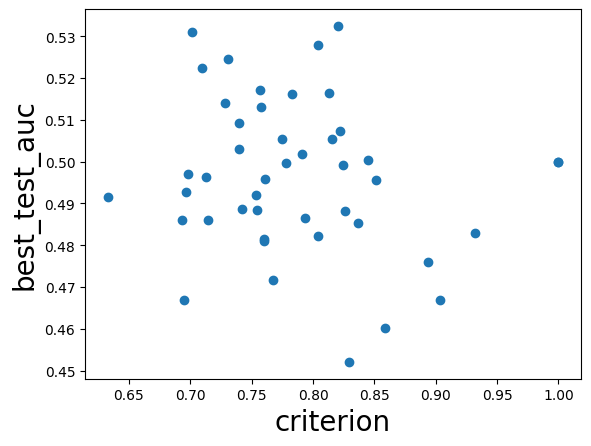

In [398]:
plt.scatter(bdd["criterion"], bdd.best_test_auc)
plt.xlabel("criterion")
plt.ylabel("best_test_auc")

Text(0, 0.5, 'test_auc')

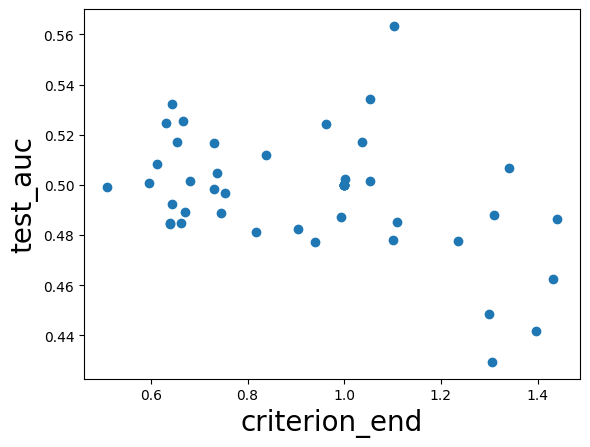

In [399]:
plt.scatter(bdd["criterion_end"], bdd.test_auc)
plt.xlabel("criterion_end")
plt.ylabel("test_auc")
# plt.xlim((0.75,0.85))

Text(0, 0.5, 'val_auc')

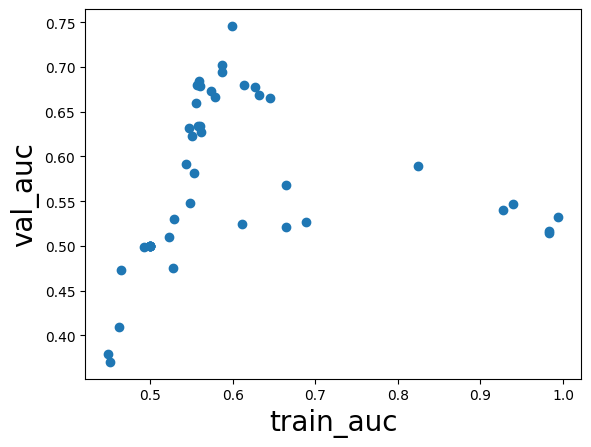

In [400]:
plt.scatter(bdd.train_auc, bdd.val_auc)
plt.xlabel("train_auc")
plt.ylabel("val_auc")

Text(0, 0.5, 'criterion')

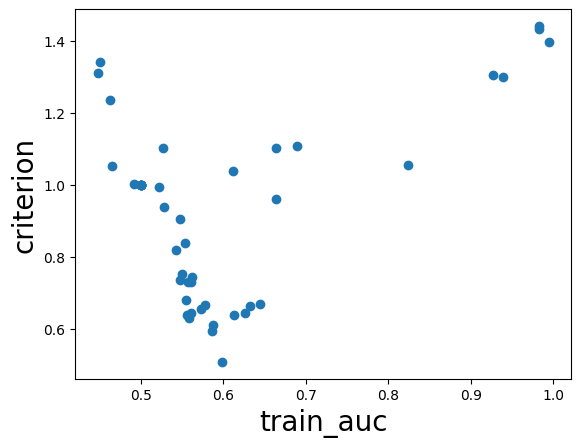

In [401]:
plt.scatter(bdd.train_auc, bdd.criterion_end)
plt.xlabel("train_auc")
plt.ylabel("criterion")

Text(0, 0.5, 'test_auc')

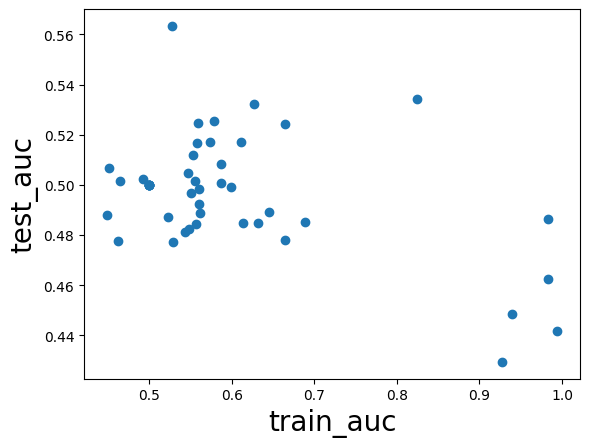

In [402]:
plt.scatter(bdd.train_auc, bdd.test_auc)
plt.xlabel("train_auc")
plt.ylabel("test_auc")

Text(0, 0.5, 'test_auc')

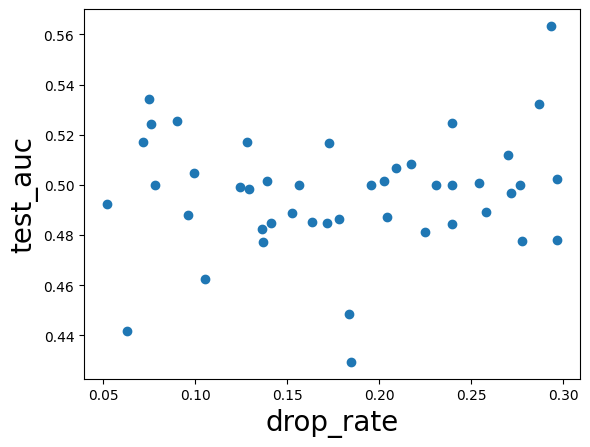

In [403]:
plt.scatter(bdd.drop_rate, bdd.test_auc)
plt.xlabel("drop_rate")
# plt.xscale("log")
plt.ylabel("test_auc")
# plt.xlim((0.75,0.85))

Text(0, 0.5, 'test_auc')

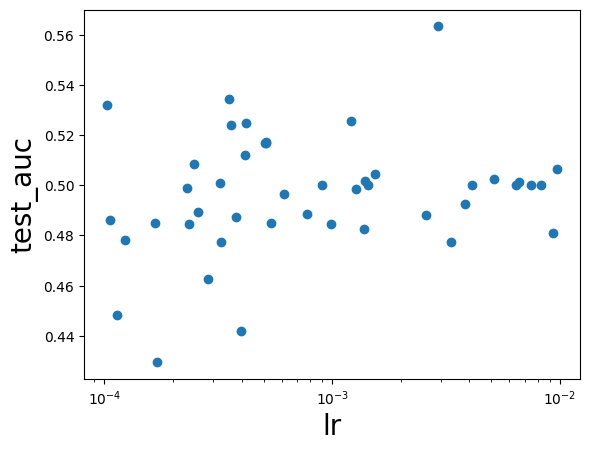

In [404]:
plt.scatter(bdd.lr, bdd.test_auc)
plt.xlabel("lr")
plt.xscale("log")
plt.ylabel("test_auc")
# plt.xlim((0.75,0.85))

(0.7, 0.85)

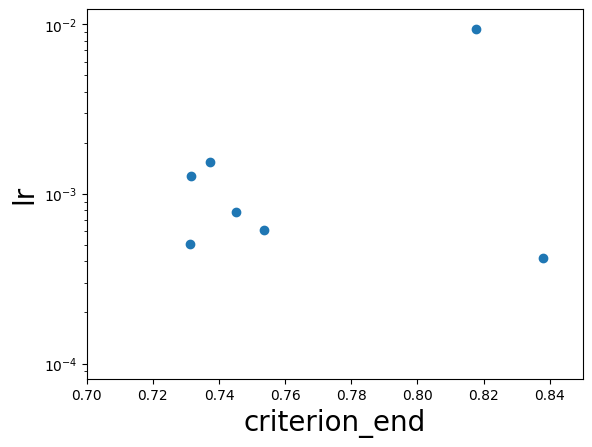

In [405]:
plt.scatter(bdd["criterion_end"], bdd.lr)
plt.xlabel("criterion_end")
plt.ylabel("lr")
plt.yscale("log")
plt.xlim((0.7,0.85))

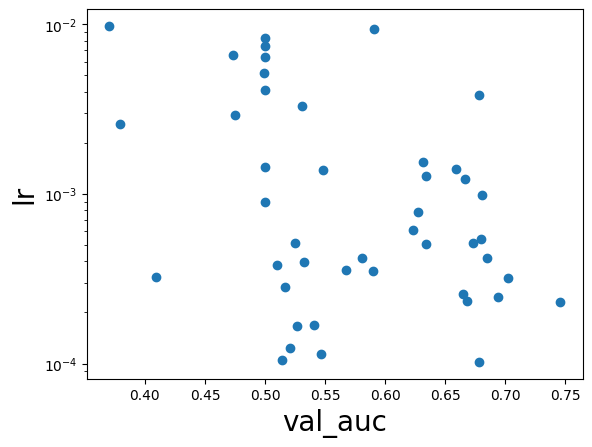

In [406]:
plt.scatter(bdd["val_auc"], bdd.lr)
plt.xlabel("val_auc")
plt.ylabel("lr")
plt.yscale("log")

(0.7, 0.85)

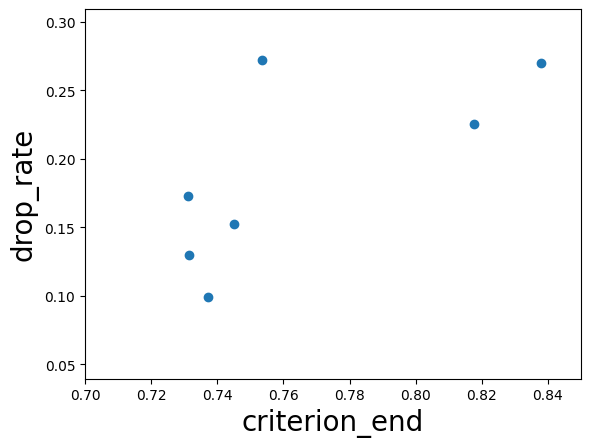

In [407]:
plt.scatter(bdd["criterion_end"], bdd.drop_rate)
plt.xlabel("criterion_end")
plt.ylabel("drop_rate")
# plt.yscale("log")
plt.xlim((0.7,0.85))

In [408]:
quantile = []
test_auc = []
test_auc_cum = []
error_cum = []
error = []
delta=0.1
quantile_x = np.arange(delta,1+delta,delta)
print(quantile_x)
for q in quantile_x:
    one_quantile = bdd['criterion_end'].quantile(q=q)
    quantile.append(one_quantile)
    test_auc_cum.append(bdd[bdd['criterion_end'] < one_quantile]['test_auc'].mean())
    error_cum.append(bdd[bdd['criterion_end'] < one_quantile]['test_auc'].sem())
    if q==delta:
        test_auc.append(test_auc_cum[-1])
        error.append(error_cum[-1])
    else:
        test_auc.append(bdd[(bdd['criterion_end'] < one_quantile) & (bdd['criterion_end'] >= quantile[-2])]['test_auc'].mean())
        error.append(bdd[(bdd['criterion_end'] < one_quantile) & (bdd['criterion_end'] >= quantile[-2])]['test_auc'].sem())

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [409]:
test_auc

[0.5034632034632034,
 0.5066017316017316,
 0.5035786435786436,
 0.4970779220779222,
 0.48820346320346314,
 0.5056998556998558,
 0.5003298289012574,
 0.5188744588744589,
 0.46013708513708507,
 0.47478354978354975]

In [410]:
error

[0.006579516949597682,
 0.010951195022363983,
 0.007832507621055348,
 0.003299699234270354,
 0.008004296399939393,
 0.01839826839826844,
 0.00032982890125746574,
 0.014444754376494246,
 0.012923979224640376,
 0.014208542731427331]

Text(0, 0.5, 'test_auc')

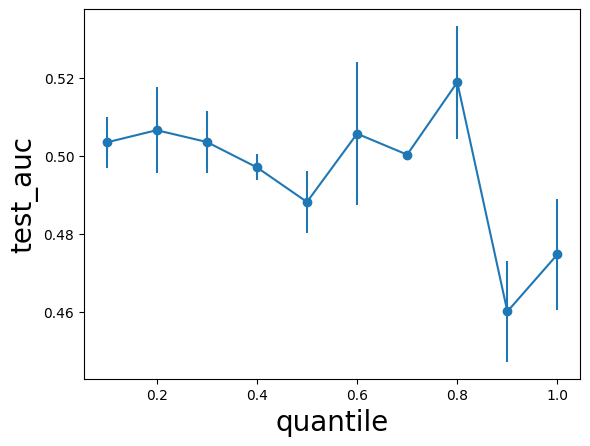

In [411]:
plt.errorbar(quantile_x, test_auc, error, marker='o')
plt.xlabel("quantile")
plt.ylabel("test_auc")
# plt.ylim((0.45,0.6))

(0.45, 0.6)

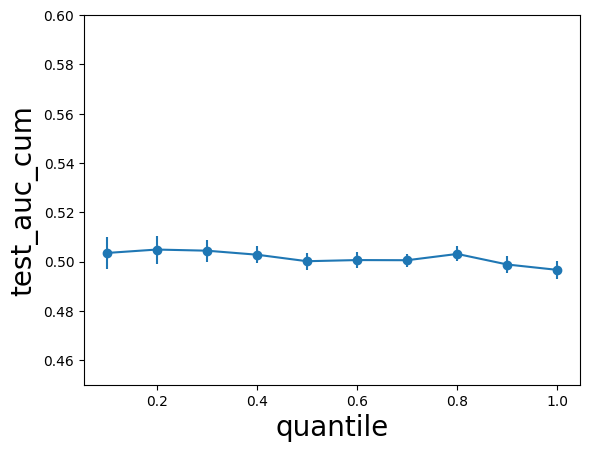

In [412]:
plt.errorbar(quantile_x, test_auc_cum, error_cum, marker='o')
plt.xlabel("quantile")
plt.ylabel("test_auc_cum")
plt.ylim((0.45,0.6))

Text(0, 0.5, 'test_auc')

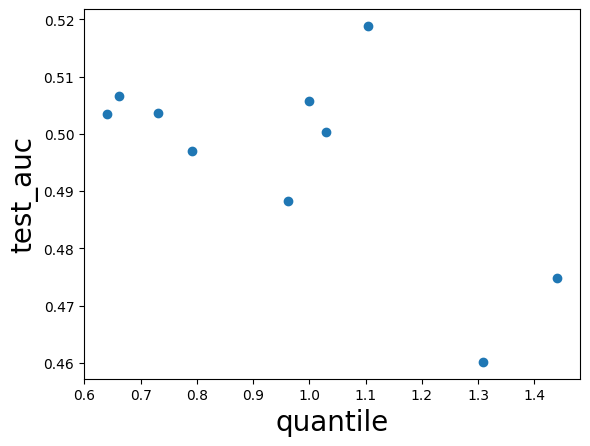

In [413]:
plt.scatter(quantile, test_auc)
plt.xlabel("quantile")
plt.ylabel("test_auc")

In [414]:
best_quantile = []
best_test_auc = []
for q in quantile_x:
    one_quantile = bdd['criterion'].quantile(q=q)
    best_quantile.append(one_quantile)
    best_test_auc.append(bdd[bdd['criterion'] < one_quantile]['best_test_auc'].mean())

Text(0, 0.5, 'best_test_auc')

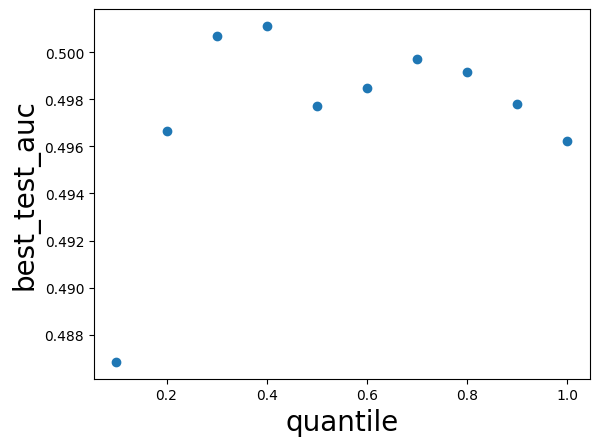

In [415]:
plt.scatter(quantile_x, best_test_auc)
plt.xlabel("quantile")
plt.ylabel("best_test_auc")

Text(0, 0.5, 'test_auc')

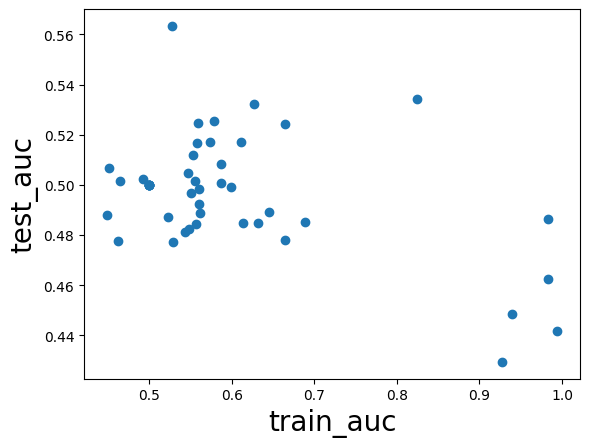

In [416]:
plt.scatter(bdd.train_auc, bdd.test_auc)
plt.xlabel("train_auc")
plt.ylabel("test_auc")

Text(0, 0.5, 'test_auc')

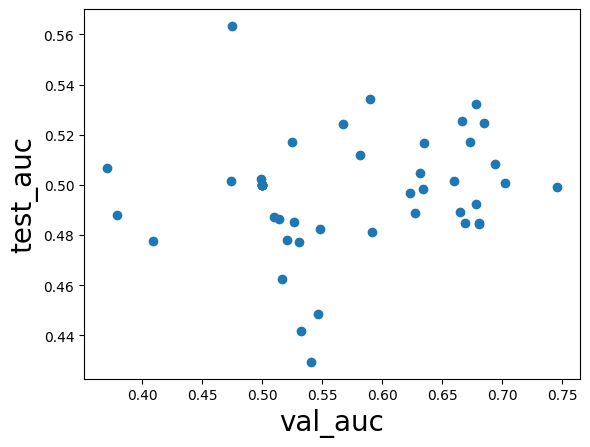

In [417]:
plt.scatter(bdd.val_auc, bdd.test_auc)
plt.xlabel("val_auc")
plt.ylabel("test_auc")

Text(0, 0.5, 'criterion')

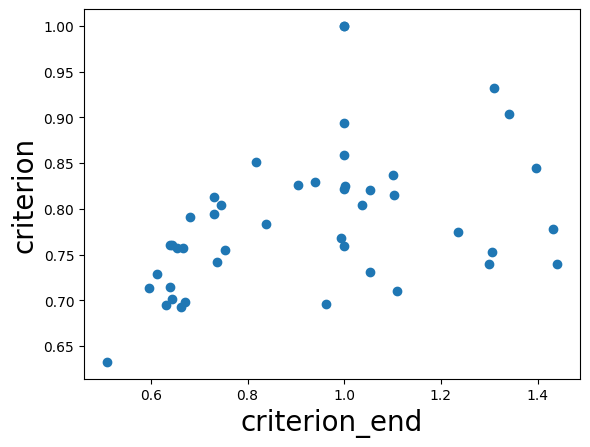

In [418]:
plt.scatter(bdd.criterion_end, bdd.criterion)
plt.xlabel("criterion_end")
plt.ylabel("criterion")

/tmp/ipykernel_36678/1393031548.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(scalarMap)


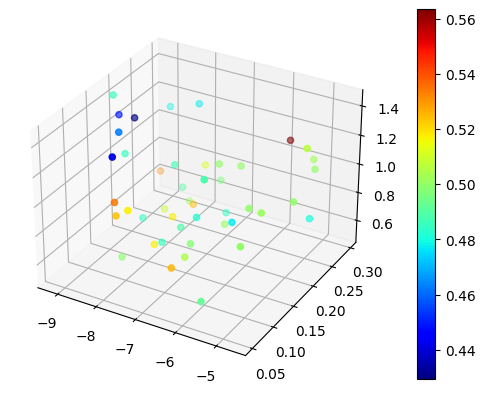

In [419]:
import matplotlib.cm as cmx
import matplotlib
colorsMap = 'jet'
cm = plt.get_cmap(colorsMap)
cs = bdd.test_auc
z = bdd.criterion_end
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
scat = ax.scatter(np.log(bdd.lr), bdd.drop_rate, z, c=scalarMap.to_rgba(cs))
scalarMap.set_array(cs)
fig.colorbar(scalarMap)

/tmp/ipykernel_36678/3606356904.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(scalarMap)


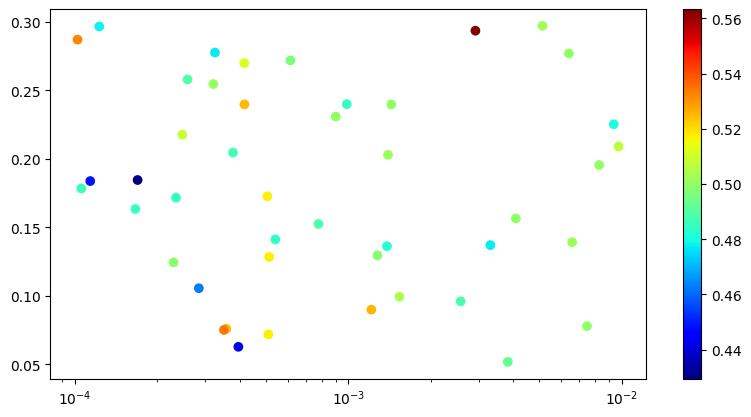

In [420]:
import matplotlib.cm as cmx
import matplotlib
colorsMap = 'jet'
cm = plt.get_cmap(colorsMap)
cs = bdd.test_auc
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1)
scat = ax.scatter(bdd.lr, bdd.drop_rate, c=scalarMap.to_rgba(cs))
ax.set_xscale("log")
scalarMap.set_array(cs)
fig.colorbar(scalarMap)

/tmp/ipykernel_36678/295477420.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(scalarMap)


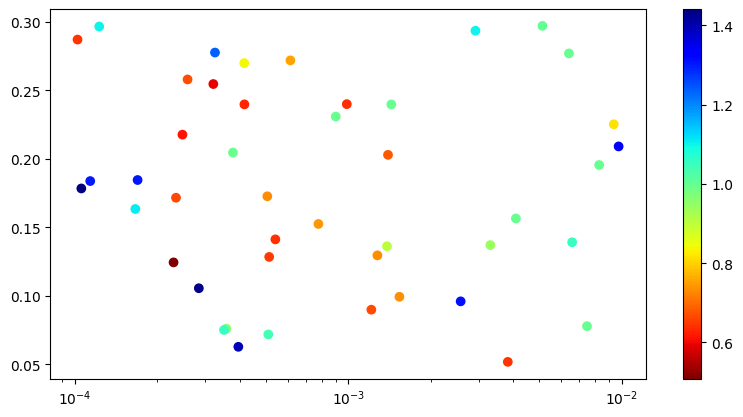

In [421]:
import matplotlib.cm as cmx
import matplotlib
colorsMap = 'jet_r'
cm = plt.get_cmap(colorsMap)
cs = bdd.criterion_end
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1)
scat = ax.scatter(bdd.lr, bdd.drop_rate, c=scalarMap.to_rgba(cs))
ax.set_xscale("log")
scalarMap.set_array(cs)
fig.colorbar(scalarMap)

Text(0, 0.5, 'val_auc')

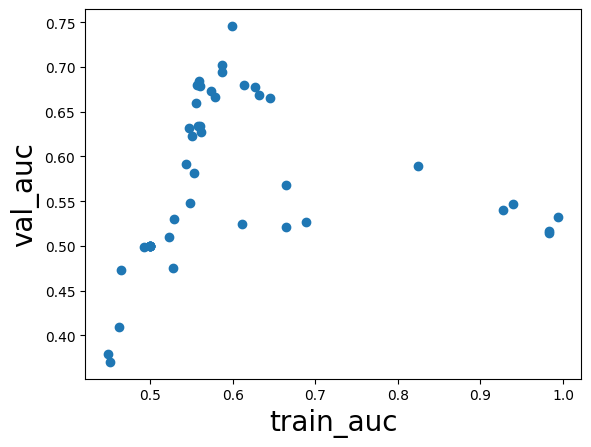

In [422]:
plt.scatter(bdd.train_auc, bdd.val_auc)
plt.xlabel("train_auc")
plt.ylabel("val_auc")

In [423]:
bdd.sort_values(by=['criterion_end'], ascending=True)

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss,criterion,criterion_end_old,criterion_end
36,/home_local/jc225751/Runs/61_classifier_regres...,0.598809,0.745827,0.498990,0.606531,0.760884,0.491631,0.124402,0.894893,0.000229,138.630814,0.632586,0.655365,0.508347
41,/home_local/jc225751/Runs/61_classifier_regres...,0.586309,0.702455,0.500722,0.585460,0.701473,0.496392,0.254461,0.794546,0.000321,138.583435,0.713067,0.711236,0.595090
32,/home_local/jc225751/Runs/61_classifier_regres...,0.587068,0.693944,0.508514,0.586287,0.685434,0.513997,0.217545,0.875238,0.000247,138.776733,0.728280,0.718988,0.612111
18,/home_local/jc225751/Runs/61_classifier_regres...,0.558944,0.684779,0.524675,0.604262,0.700491,0.466955,0.239622,0.898063,0.000417,138.457809,0.695247,0.756277,0.630442
17,/home_local/jc225751/Runs/61_classifier_regres...,0.556052,0.680360,0.484416,0.557547,0.682488,0.481097,0.239798,0.867935,0.000988,138.769058,0.759965,0.763588,0.639280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,/home_local/jc225751/Runs/61_classifier_regres...,0.447967,0.379214,0.488023,0.524991,0.543044,0.482973,0.095999,0.900809,0.002577,138.596725,0.931964,1.310323,1.310323
27,/home_local/jc225751/Runs/61_classifier_regres...,0.451152,0.370376,0.506638,0.523887,0.572668,0.466955,0.208968,0.726272,0.009754,138.642563,0.903445,1.340022,1.340022
25,/home_local/jc225751/Runs/61_classifier_regres...,0.994547,0.532570,0.441847,0.705512,0.620295,0.500433,0.062854,0.769009,0.000396,134.093658,0.844628,1.396838,1.396838
21,/home_local/jc225751/Runs/61_classifier_regres...,0.983249,0.516858,0.462626,0.675390,0.632406,0.499567,0.105564,0.762316,0.000284,120.333130,0.778173,1.432676,1.432676
